# OFDM Channel Estimation


In another post, we looked at how Orthogonal Frequency Division Multiplexing (OFDM) works and why it is a preferred waveform for applications such as WiFi, LTE and 5G-NR. There is a large body of work on efficient OFDM channel estimation, pilot placement and interpolation. However, the goal of this post is to give the reader a clear understanding of a working channel estimation scheme. Therefore, we look at how a simple channel estimation can be performed on a WiFi packet with multiple OFDM symbols and possibly decode the packet.

## WiFi OFDM Features

1. Start of signal contains known training sequences(repeating) on all subcarriers. These training sequences are used to detect the beginning of the packet through time-domain correlation.
2. The training sequences are also used to find the channel estimate for all 64 sub-carriers. It is assumed that the coherence time of the channel is much larger than the transmission time.
3. The channel estimates in 2. are used to equalize the rest of the OFDM symbols. 
4. Since each carrier is orthogonal in OFDM, known symbols could be modulated in a predetermined way so that certain errors may be identified and calibrated out. These known symbols are called pilots. There are different strategies to place pilots in the OFDM signal. Some are illustrated below:
<img src="pilot_infographic.png"/>
The training sequences at the beginning of the WiFi packet may also be thought of as pilots. Since the training sequences are present on all subcarriers, they are a form of block-type pilots. Added to this, four subcarriers are reserved in every OFDM symbol for pilots (same four across all symbols). Therefore, a WiFi packet has a block type pilot in the beginning (for detection and channel estimation) and comb type pilots throughout the packet (for frequency, phase tracking). LTE on the other hand, uses scattered pilots.

### CFO, Phase Error, and SFO (Courtesy WARP)

Typically, a transmitter and receiver are each clocked independently. This independence manifests in three different degradations that must be dealt with by a wireless receiver:

1. **Carrier Frequency Offset (CFO)** - The center frequency of the transmitter will not perfectly match the center frequency of the receiver. Unless corrected, this will de-orthogonalize the OFDM subcarriers and cause inter-carrier interference (ICI). CFO is typically corrected in the time domain via multiplication with a digital carrier whose frequency negates the CFO estimate. This example uses a technique that compares two sequential preamble training symbols to estimate the CFO [4].
2. **Phase Error** - Even after CFO is corrected in the time domain, there is typically a residual phase error component that must be corrected in the frequency domain and tracked over time. OFDM systems employ multiple pilot subcarriers to enable this correction system. All data subcarriers in each OFDM symbol are phase-rotated to match any residual rotation observed in the known pilots.
3. **Sampling Frequency Offset (SFO)** - The temporal duration of a sample is slightly different at the receiver and transmitter due to different sampling clocks. Over the course of a reception, the relative sample periods will drift apart from one another. This manifests as larger phase error for the outer subcarriers [5]. Each data subcarrier in each OFDM symbol is phase-rotated differently according to its subcarrier index.

The coding example in this notebook follows this block diagram:

<img src="wl_ofdm_blkDiag_Rx.png"/>


## Example Code

In [2]:
############################################################################
# A detailed write-up of this example is available on the wiki:
# http://warpproject.org/trac/wiki/WARPLab/Examples/OFDM
# Distributed under the WARP License (http://warpproject.org/license)
#
# Python conversion and 802.11a pilot addition by Raghav Vaidyanathan Subbaraman
############################################################################

# The below is a command to force the ipynb to plot inline instead of popping a window
%matplotlib inline
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# # Params:
USE_WARPLAB_TXRX        = 0;           # Enable WARPLab-in-the-loop (otherwise sim-only)
WRITE_PNG_FILES         = 0;           # Enable writing plots to PNG
CHANNEL                 = 11;          # Channel to tune Tx and Rx radios

# Waveform params
N_OFDM_SYMS             = 95;         # Number of OFDM symbols
MOD_ORDER               = 2;           # Modulation order (2/4/16/64 = BSPK/QPSK/16-QAM/64-QAM)
TX_SCALE                = 1.0;          # Scale for Tx waveform ([0:1])

# OFDM params
SC_IND_PILOTS           = np.array([7,21,43,57]);                 # Pilot subcarrier indices
SC_IND_DATA             = np.array([1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,38,39,40,41,42,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,60,61,62,63]);     # Data subcarrier indices
N_SC                    = 64;                                     # Number of subcarriers
CP_LEN                  = 16;                                     # Cyclic prefix length
N_DATA_SYMS             = N_OFDM_SYMS * len(SC_IND_DATA);      # Number of data symbols (one per data-bearing subcarrier per OFDM symbol)

# Rx processing params
FFT_OFFSET                    = 4;           # Number of CP samples to use in FFT (on average)
LTS_CORR_THRESH               = 0.8;         # Normalized threshold for LTS correlation
DO_APPLY_CFO_CORRECTION       = 1;           # Enable CFO estimation/correction
DO_APPLY_PHASE_ERR_CORRECTION = 1;           # Enable Residual CFO estimation/correction
DO_APPLY_SFO_CORRECTION       = 1;           # Enable SFO estimation/correction

In [3]:
# STS
sts_f = np.zeros((1,64),'complex');
sts_f[0,0:27] = [0,0,0,0,-1-1j,0,0,0,-1-1j,0,0,0,1+1j,0,0,0,1+1j,0,0,0,1+1j,0,0,0,1+1j,0,0];
sts_f[0,38:]= [0,0,1+1j,0,0,0,-1-1j,0,0,0,1+1j,0,0,0,-1-1j,0,0,0,-1-1j,0,0,0,1+1j,0,0,0];
sts_t = np.fft.ifft(np.sqrt(13/6)*sts_f[0,:],64);
sts_t = sts_t[0:16];

# LTS for CFO and channel estimation
lts_t = np.zeros((1,64),'complex')
lts_f = [0,1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,-1,-1,1,1,-1,-1,1,-1,1,-1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,-1,-1,1,1,-1,1,-1,1,1,1,1,1,1,-1,-1,1,1,-1,1,-1,1,1,1,1];
lts_t[0,:] = np.fft.ifft(lts_f,64);

# Generation of expected preamble
preamble = np.matlib.repmat(sts_t, 1, 30);
preamble = np.concatenate((preamble[0,:],lts_t[0,32:],lts_t[0,:],lts_t[0,:]),axis=0);

# Define the pilot tone values as BPSK symbols from 802.11 standards
pilots = np.array([1,-1,1,1]); 
# Pseudo-Random pilot multiplication IEEE 802.11a - 1999 17.3.5.8
pilot_screw = np.array([1,1,1,1,-1,-1,-1,1, -1,-1,-1,-1,1,1,-1,1, -1,-1,1,1,-1,1,1,-1, 1,1,1,1,1,1,-1,1, 1,1,-1,1,1,-1,-1,1, 1,1,-1,1,-1,-1,-1,1, -1,1,-1,-1,1,-1,-1,1, 1,1,1,1,-1,-1,1,1, -1,-1,1,-1,1,-1,1,1, -1,-1,-1,1,1,-1,-1,-1, -1,1,-1,-1,1,-1,1,1, 1,1,-1,1,-1,1,-1,1, -1,-1,-1,-1,-1,1,-1,1, 1,-1,1,-1,1,1,1,-1, -1,1,-1,-1,-1,1,1,1, -1,-1,-1,-1,-1,-1,-1]);
# Repeat the pilots across all OFDM symbols
pilots_mat = np.transpose(np.matlib.repmat(pilots, N_OFDM_SYMS, 1));

for ind in range(0,N_OFDM_SYMS):
    pilots_mat[:,ind] = pilot_screw[np.mod(ind,126)]*pilots_mat[:,ind]; 


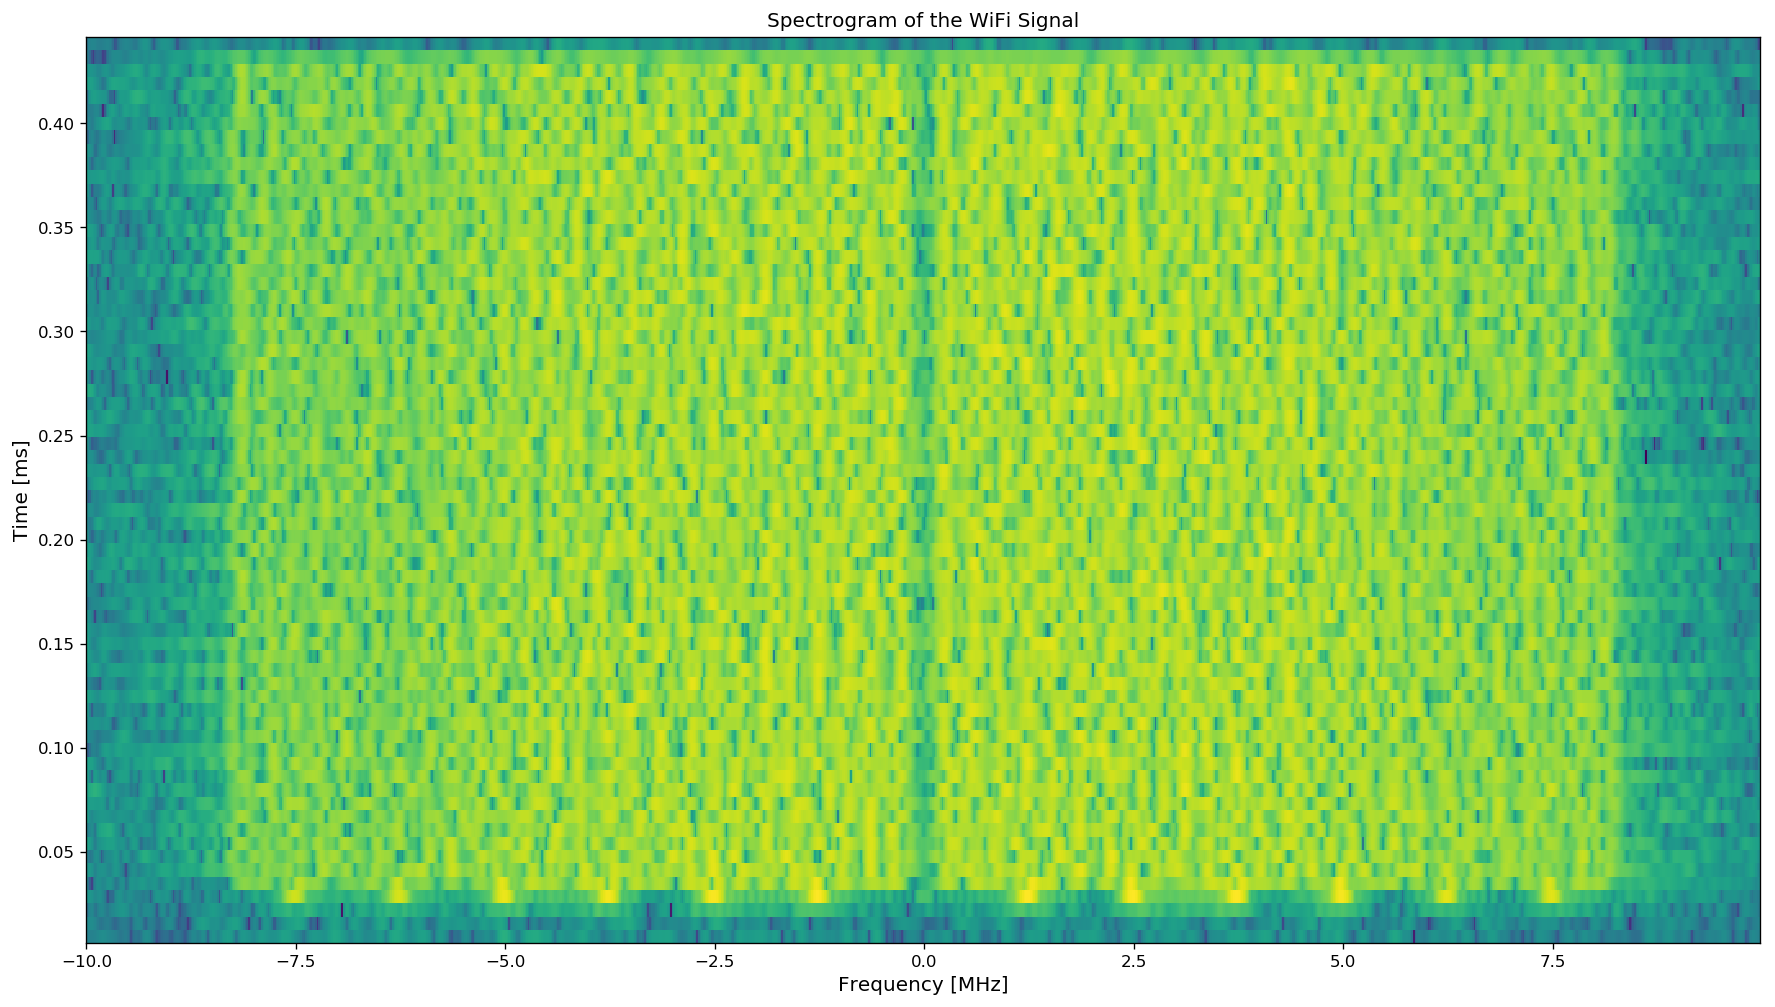

In [14]:
# Read the captured IQ sample file

df = pd.read_csv('https://raw.githubusercontent.com/varun19299/wireless-lab-iitm/master/notebooks/06/wifi_data.csv')

raw_rx_i=np.asarray(df['I'][:])
raw_rx_q=np.asarray(df['Q'][:])
raw_rx_dec=raw_rx_i+1j*raw_rx_q
raw_rx_dec = np.zeros((1,len(raw_rx_dec)),'complex')
raw_rx_dec[0,:] = raw_rx_i+1j*raw_rx_q


# Setting figure dimensions
fig = plt.figure(figsize=(18, 10), dpi= 120, facecolor='w', edgecolor='k')
# Plotting the spectrogram
f, t, Sxx = signal.spectrogram(raw_rx_dec,20e6,window=('hamming'),nperseg=256,noverlap=128,nfft=1024,mode='psd')
plt.pcolormesh(np.fft.fftshift(f)*1e-6,t*1e3,10*np.log10(np.transpose(np.fft.fftshift(Sxx[0,:,:], axes=0))))
plt.xlabel('Frequency [MHz]',fontsize='large');
plt.ylabel('Time [ms]',fontsize='large');
plt.title('Spectrogram of the WiFi Signal',fontsize='large');

In [15]:
## Correlate for LTS

# Complex cross correlation of Rx waveform with time-domain LTS
flip_lts = np.fliplr(lts_t);
rx_raw_dec_abs = np.abs(raw_rx_dec[0,:]);
lts_corr = abs(np.convolve(np.conj(flip_lts[0,:]), raw_rx_dec[0,:]/rx_raw_dec_abs));

# Skip early and late samples - avoids occasional false positives from pre-AGC samples
lts_corr = lts_corr[31:-32];

# Find all correlation peaks
lts_peaks = np.argwhere(lts_corr[1:800] > LTS_CORR_THRESH*max(lts_corr));

# Select best candidate correlation peak as LTS-payload boundary
# TODO, error handling
[LTS1, LTS2] = np.meshgrid(lts_peaks,lts_peaks);
[lts_second_peak_index] = np.argwhere(LTS2-LTS1 == np.shape(lts_t)[1]);

# Stop if no valid correlation peak was found
# if(isempty(lts_second_peak_index))
#     fprintf('No LTS Correlation Peaks Found!\n');
#     return;
# Set the sample indices of the payload symbols and preamble
# The "+32" corresponds to the 32-sample cyclic prefix on the preamble LTS
# The "-160" corresponds to the length of the preamble LTS (2.5 copies of 64-sample LTS)
payload_ind = lts_peaks[np.max(lts_second_peak_index)][0] + 33;
lts_ind = payload_ind-160;
# lts_ind = lts_ind+1

In [16]:
## CFO Correction

if(DO_APPLY_CFO_CORRECTION):
    #Extract LTS (not yet CFO corrected)
    rx_lts = raw_rx_dec[0,lts_ind : lts_ind+159];
    rx_lts1 = rx_lts[-64+-FFT_OFFSET + 96:-64+-FFT_OFFSET +160];  # Check indexing
    rx_lts2 = rx_lts[-FFT_OFFSET+96:-FFT_OFFSET+160];

    #Calculate coarse CFO est
    rx_cfo_est_lts = np.mean(np.unwrap(np.angle(rx_lts2 * np.conj(rx_lts1))));
    rx_cfo_est_lts = rx_cfo_est_lts/(2*np.pi*64);
else:
    rx_cfo_est_lts = 0;
    
# Apply CFO correction to raw Rx waveform
time_vec = np.arange(0,np.shape(raw_rx_dec)[1],1);
rx_cfo_corr_t = np.exp(-1j*2*np.pi*rx_cfo_est_lts*time_vec);
rx_dec_cfo_corr = raw_rx_dec * rx_cfo_corr_t;


In [17]:
# Re-extract LTS for channel estimate
rx_lts = rx_dec_cfo_corr[0,lts_ind : lts_ind+159];
rx_lts1 = rx_lts[-64+-FFT_OFFSET + 96:-64+-FFT_OFFSET +160];  # Check indexing
rx_lts2 = rx_lts[-FFT_OFFSET+96:-FFT_OFFSET+160];

rx_lts1_f = np.fft.fft(rx_lts1);
rx_lts2_f = np.fft.fft(rx_lts2);

# Calculate channel estimate from average of 2 training symbols
rx_H_est = lts_f * (rx_lts1_f + rx_lts2_f)/2;


In [28]:
## Rx payload processing
np.seterr(divide='ignore')

# Extract the payload samples (integral number of OFDM symbols following preamble)
payload_vec = rx_dec_cfo_corr[0,payload_ind : payload_ind+N_OFDM_SYMS*(N_SC+CP_LEN)];
payload_mat = np.matlib.reshape(payload_vec, (N_OFDM_SYMS,(N_SC+CP_LEN) ));
payload_mat = np.transpose(payload_mat)

# Remove the cyclic prefix, keeping FFT_OFFSET samples of CP (on average)
payload_mat_noCP = payload_mat[CP_LEN-FFT_OFFSET:CP_LEN-FFT_OFFSET+N_SC, :];

# Take the FFT
syms_f_mat = np.fft.fft(payload_mat_noCP, N_SC, axis=0);

# Equalize (zero-forcing, just divide by complex chan estimates)
# Indexing issue
rep_rx_H = np.transpose(np.matlib.repmat(rx_H_est, N_OFDM_SYMS,1))
syms_eq_mat = syms_f_mat / rep_rx_H;

In [31]:
# SFO Correction
if DO_APPLY_SFO_CORRECTION:
    # SFO manifests as a frequency-dependent phase whose slope increases
    # over time as the Tx and Rx sample streams drift apart from one
    # another. To correct for this effect, we calculate this phase slope at
    # each OFDM symbol using the pilot tones and use this slope to
    # interpolate a phase correction for each data-bearing subcarrier.

    # Extract the pilot tones and "equalize" them by their nominal Tx values
    pilots_f_mat = syms_eq_mat[SC_IND_PILOTS, :];
    pilots_f_mat_comp = pilots_f_mat*pilots_mat;

    # Calculate the phases of every Rx pilot tone
    pilot_phases = np.unwrap(np.angle(np.fft.fftshift(pilots_f_mat_comp,0)),axis=-1);

    # Calculate slope of pilot tone phases vs frequency in each OFDM symbol
    pilot_spacing_mat = np.matlib.repmat(np.mod(np.diff(np.fft.fftshift(SC_IND_PILOTS)),64), N_OFDM_SYMS, 1);  
    pilot_spacing_mat = np.transpose(pilot_spacing_mat)
    pilot_slope_mat = np.mean(np.transpose(np.diff(np.transpose(pilot_phases))) / pilot_spacing_mat,0);

    # Calculate the SFO correction phases for each OFDM symbol
    # INDEXES
    pilot_phase_sfo_corr = np.fft.fftshift(np.outer(np.arange(-32,32,1),(pilot_slope_mat)),0);
    pilot_phase_corr = np.exp(-1j*(pilot_phase_sfo_corr));

    # Apply the pilot phase correction per symbol
    syms_eq_mat = syms_eq_mat * pilot_phase_corr;
else:
    # Define an empty SFO correction matrix (used by plotting code below)
    pilot_phase_sfo_corr = np.zeros((N_SC, N_OFDM_SYMS),'complex');


In [32]:
# Phase error correction
if DO_APPLY_PHASE_ERR_CORRECTION:
    # Extract the pilots and calculate per-symbol phase error
    pilots_f_mat = syms_eq_mat[SC_IND_PILOTS, :];
    pilots_f_mat_comp = pilots_f_mat*pilots_mat;
    pilot_phase_err = np.angle(np.mean(pilots_f_mat_comp,0));
else:
    # Define an empty phase correction vector (used by plotting code below)
    pilot_phase_err = np.zeros((1, N_OFDM_SYMS),'complex');

pilot_phase_err_corr = np.matlib.repmat(pilot_phase_err, N_SC, 1);
pilot_phase_corr = np.exp(-1j*(pilot_phase_err_corr));

# Apply the pilot phase correction per symbol
syms_eq_pc_mat = syms_eq_mat * pilot_phase_corr;

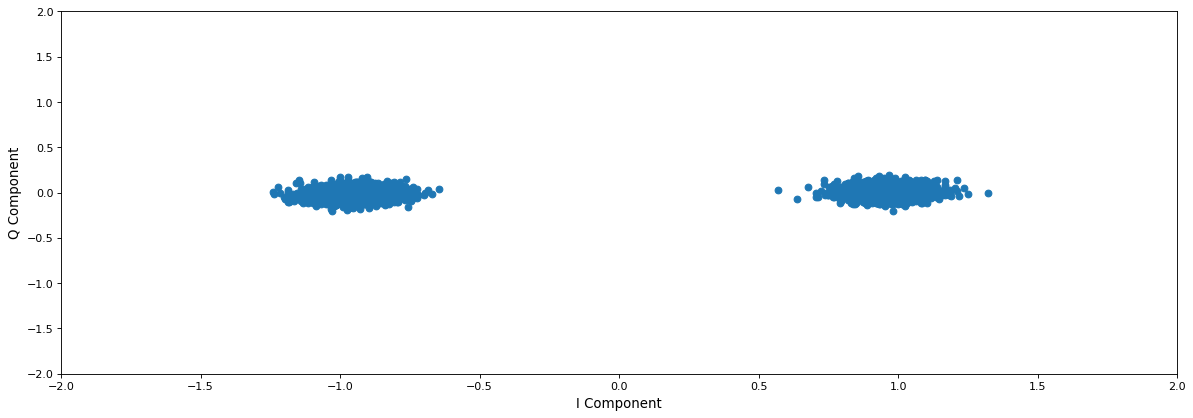

In [33]:
payload_syms_mat = syms_eq_pc_mat[SC_IND_DATA, :];

## Demodulate
rx_syms = np.reshape(payload_syms_mat,(1, N_DATA_SYMS));
# Setting figure dimensions
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(np.real(rx_syms),np.imag(rx_syms));
plt.xlim([-2,2]);
plt.ylim([-2,2]);
plt.xlabel('I Component',fontsize='large');
plt.ylabel('Q Component',fontsize='large');

## Problems

1. What modulation scheme was used in the WiFi packet that we equalised?
2. Write a code-snippet that will demodulate the scheme in 1. to bits
3. Change the variables ``DO_APPLY_CFO_CORRECTION``,``DO_APPLY_PHASE_ERR_CORRECTION``,``DO_APPLY_SFO_CORRECTION`` and observe the effects. What happens when you set ``DO_APPLY_CFO_CORRECTION=0``,``DO_APPLY_PHASE_ERR_CORRECTION=1``,``DO_APPLY_SFO_CORRECTION=1``? Does the equalization still work?, if so, why?
4. Plot the envelope of ``rx_H_est`` and see how the channel varies across the subcarriers.

## References

1. Andrea Goldsmith - Wireless Communications (2005, Cambridge University Press)
2. WARP Project http://warpproject.org/
3. [DSP Illustrations](https://dspillustrations.com/pages/pages/courses/course_OFDM/html/05%20-%20OFDM%20Channel%20Estimation%20%281%29.html)
4. Schmidl, Timothy M., and Donald C. Cox. "Robust frequency and timing synchronization for OFDM." Communications, IEEE Transactions on 45.12 (1997): 1613-1621.
5. Speth, Michael, et al. "Optimum receiver design for wireless broad-band systems using OFDM. I." Communications, IEEE Transactions on 47.11 (1999): 1668-1677.